# Final Project Check-in 2018-11-16

## Group Name: Lambda

### Student Names
1. Jian Wang
2. Chong Geng
3. Alan Perry
4. Divya Bhargavi
5. Robert Sandor

## Load Data

In [1]:
from collections import defaultdict
from math import sqrt
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
import operator
import re
from scipy import spatial
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import string
import time

In [2]:
modified_train = pd.read_csv('combined.csv', encoding='ISO-8859-1')
modified_train.drop(columns=['Unnamed: 0']).head(1)

,index,product_uid,product_title,search_term,relevance,id,product_description,cleaned_terms,stemmed_terms,stemmed_title,...,stemmed_terms_in_title,stemmed_terms_in_desc,lemmatized_terms_in_title,lemmatized_terms_in_desc,neighbours_in_title,neighbours_in_desc,search_term_in_attrib,color_in_search_term,min_levenstein_dist_title,min_levenstein_dist_brand
0,0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.0,2,"Not only do angles make joints stronger, they ...",angle bracket,angl bracket,simpson strong tie gaug angl,...,1.0,1.0,1.0,1.0,0.0,1.0,1,0,10.0,0.001


## Fit scikit-learn model

In [3]:
# choice 1
X_train = modified_train[['clean_length', 'title_length', 
                          'desc_length', 'clean_terms_in_title', 
                          'clean_terms_in_desc', 'stemmed_terms_in_title',
                          'stemmed_terms_in_desc','lemmatized_terms_in_title',
                          'lemmatized_terms_in_desc','neighbours_in_title',
                         'neighbours_in_desc','min_levenstein_dist_brand',
                          'min_levenstein_dist_title','color_in_search_term',
                         'search_term_in_attrib','neighbours_in_desc',
                         'neighbours_in_title', 'lemmatized_terms_in_desc',]]
y_train = modified_train[['relevance']]

In [4]:
# since we can't see the relevancy scores of the test set,
# I decided to split the training set 
train_data, test_data, train_target, test_target = train_test_split(X_train,
                                                                        y_train, random_state=42)

In [5]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(train_data, train_target)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [6]:
predicted = lin_reg_model.predict(test_data)
print(predicted[:5])
print(test_target[:5])

[[2.02337346]
 [2.19124392]
 [2.32077374]
 [2.65426502]
 [2.69076532]]
       relevance
13534       3.00
29748       2.67
20225       2.67
5169        2.67
49860       2.00


## Evaluation Metric

In [7]:
# since an RMSE function couldn't be found quickly in the sklearn library,
# we just used the MSE function and took the square root of that
rmse_lin_reg = sqrt(mean_squared_error(predicted, test_target))

# this value is equivalent to rank 1680 on the Kaggle leaderboard for this competition
# the benchmark was ~ rank 1681
# https://www.kaggle.com/c/home-depot-product-search-relevance/leaderboard
print(f"{rmse_lin_reg:.4f}")

0.4997


In [8]:
train_data.head()


,clean_length,title_length,desc_length,clean_terms_in_title,clean_terms_in_desc,stemmed_terms_in_title,stemmed_terms_in_desc,lemmatized_terms_in_title,lemmatized_terms_in_desc,neighbours_in_title,neighbours_in_desc,min_levenstein_dist_brand,min_levenstein_dist_title,color_in_search_term,search_term_in_attrib,neighbours_in_desc,neighbours_in_title,lemmatized_terms_in_desc
62710,1.0,12.0,101.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.001,1.0,0,1,1.0,1.0,1.0
852,3.0,13.0,121.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.001,10.0,0,1,0.0,0.0,2.0
67325,3.0,13.0,178.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,0.001,10.0,0,2,3.0,1.0,2.0
9523,4.0,12.0,104.0,3.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0,0.001,10.0,0,2,3.0,2.0,2.0
70415,2.0,19.0,237.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.001,10.0,0,1,1.0,0.0,1.0


Random Forrest

In [9]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import cross_val_score

In [10]:
estimator_list = [('random_forrest', RandomForestRegressor())]

parameter_list = [{
                'random_forrest__n_estimators': [1,2,3],
                'random_forrest__max_depth': [1,2],
                'random_forrest__max_features':[2,3,4],
    'random_forrest__min_samples_split':[2],
                }]
best_model = GridSearchCV(LinearRegression(),{},cv=5)

grid = GridSearchCV(estimator=Pipeline(estimator_list), 
                    param_grid=parameter_list, 
                   refit=True, 
                    scoring=make_scorer(mean_squared_error),
                    cv=5)
rmse_list = []
for x in range(10):
    if type(train_target) != np.ndarray:
        y = train_target.values.ravel()
        train_target = np.array(y).astype(float)
    best_model = grid.fit(train_data, train_target.ravel())
    print(best_model.best_estimator_)
    print(sqrt(best_model.score(test_data, test_target)))
    rmse_list.append(sqrt(best_model.score(test_data, test_target)))

Pipeline(memory=None,
     steps=[('random_forrest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1, n_jobs=None, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])
0.5242752978924291
Pipeline(memory=None,
     steps=[('random_forrest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1, n_jobs=None, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])
0.5256058533586186
Pipeline(memory=None,
     steps=[('random_forrest', RandomForestRegressor(bootstrap=True, crite

10


(array([0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.52      , 0.52020202, 0.52040404, 0.52060606, 0.52080808,
        0.5210101 , 0.52121212, 0.52141414, 0.52161616, 0.52181818,
        0.5220202 , 0.52222222, 0.52242424, 0.52262626, 0.52282828,
        0.5230303 , 0.52323232, 0.52343434, 0.52363636, 0.52383838,
        0.5240404 , 0.52424242, 0.52444444, 0.52464646, 0.52484848,
        0.52505051, 0.52525253, 0.52545455, 0.52565657, 0.52585859,
        0.52606061, 0.52626263, 0.52646465, 0.52666667, 0.52686869,
        0.52707071, 0.52727273, 0.52747475, 0.52767677, 0.52787879,
        0.

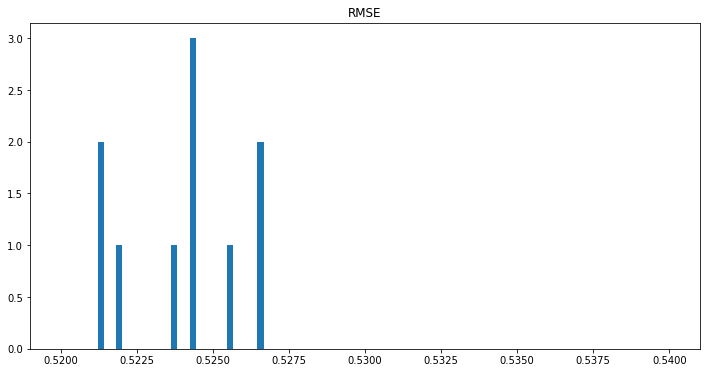

In [17]:
print(len(rmse_list))
plt.figure(figsize=(12, 6))


plt.title('RMSE')

plt.hist(rmse_list,bins=np.linspace(0.52,0.54,100))

#for postfix in ['.png','.pdf']:
#    name = 'treeRMSE'+postfix
#plt.savefig(name,bbox_inches='tight')

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

In [28]:
# Fit regression model 


estimator_list = [('gbr', GradientBoostingRegressor())]

parameter_list = [{
                'gbr__n_estimators': [1],
    'gbr__max_features':[1,3,15]   ,         
    'gbr__max_depth': [1,10],
                'gbr__learning_rate':[0.01],
                'gbr__min_samples_split':[2],
                }]
best_model = GridSearchCV(LinearRegression(),{},cv=5)
rmse_list = []
grid = GridSearchCV(estimator=Pipeline(estimator_list), 
                    param_grid=parameter_list, 
                    refit=True, 
                    scoring=make_scorer(mean_squared_error),
                    cv=5)
for x in range(10):
    grid.fit(train_data, train_target)
    predicted= grid.predict(test_data)
    rmse_lin_reg = sqrt(mean_squared_error(predicted, test_target))
    print(rmse_lin_reg)
    rmse_list.append(rmse_lin_reg)


0.5345713589257188
0.5345550109297954
0.5343865058357197
0.5345656599945571
0.5344218742912026
0.5343810930553102
0.5343865058357197
0.5344170176440549
0.5344170176440549
0.5345687084805625


(array([3., 2., 1., 0., 0., 0., 0., 0., 0., 4.]),
 array([0.53438109, 0.53440012, 0.53441915, 0.53443817, 0.5344572 ,
        0.53447623, 0.53449525, 0.53451428, 0.53453331, 0.53455233,
        0.53457136]),
 <a list of 10 Patch objects>)

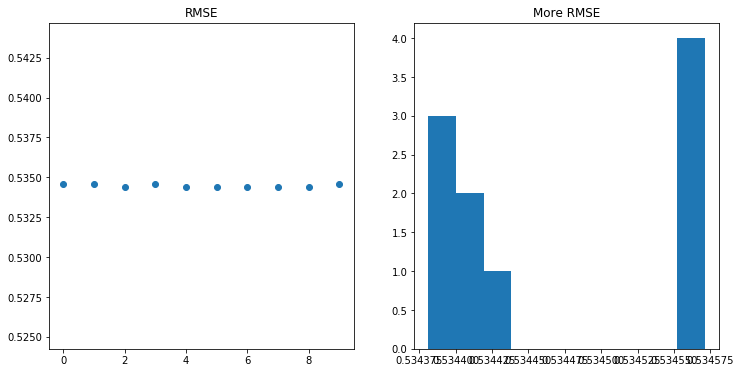

In [29]:
#print(rmse_list)
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.title('RMSE')
plt.scatter(range(10),rmse_list)
plt.subplot(1, 2, 2)
plt.title('More RMSE')

plt.hist(rmse_list)


#for postfix in ['.png','.pdf']:
#    name = 'greRMSE'+postfix
#plt.savefig(name,bbox_inches='tight')
